ACTIVE LEARNING TRAININGSZEITEN-ANALYSE

Datensatz geladen: 500 Einträge
Klassifikatoren: 5
Query-Strategien: 4
Budget-Stufen: 5
Wiederholungen pro Konfiguration: 5


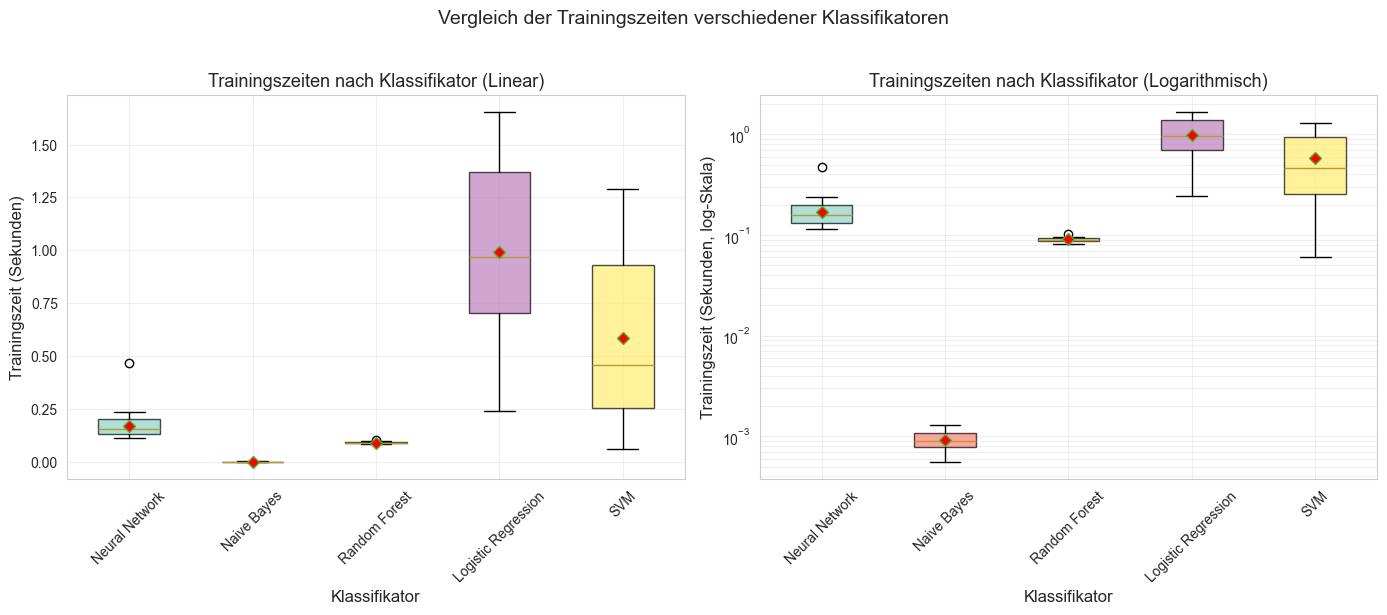

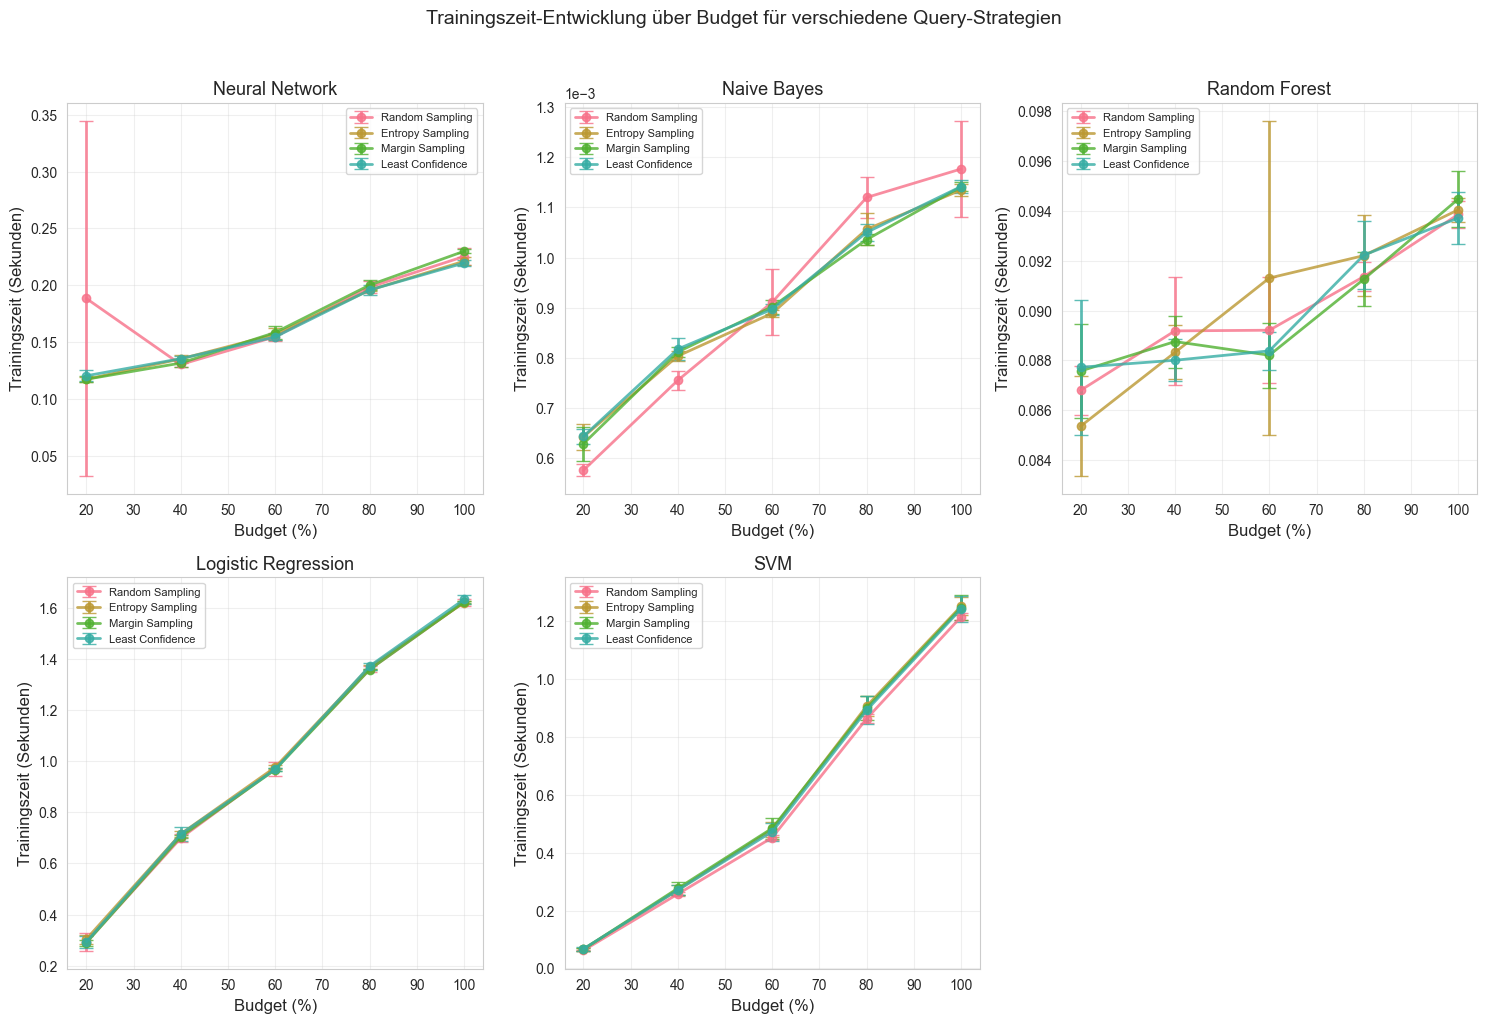

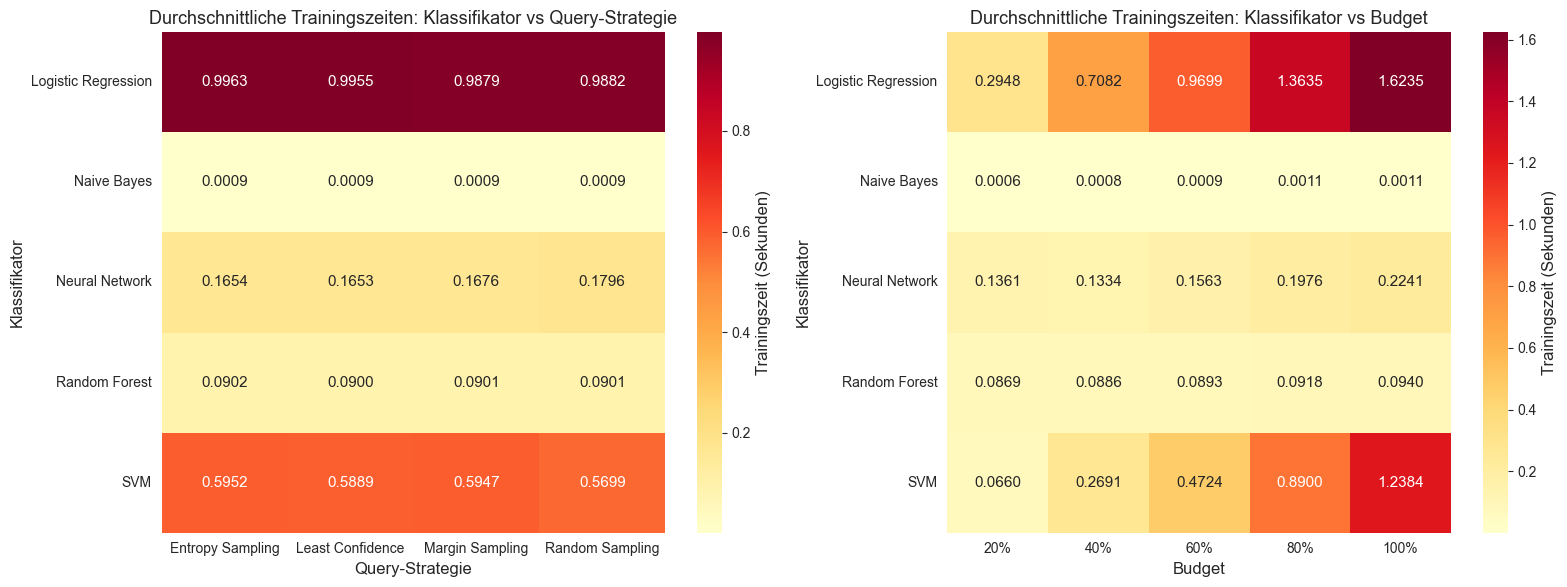

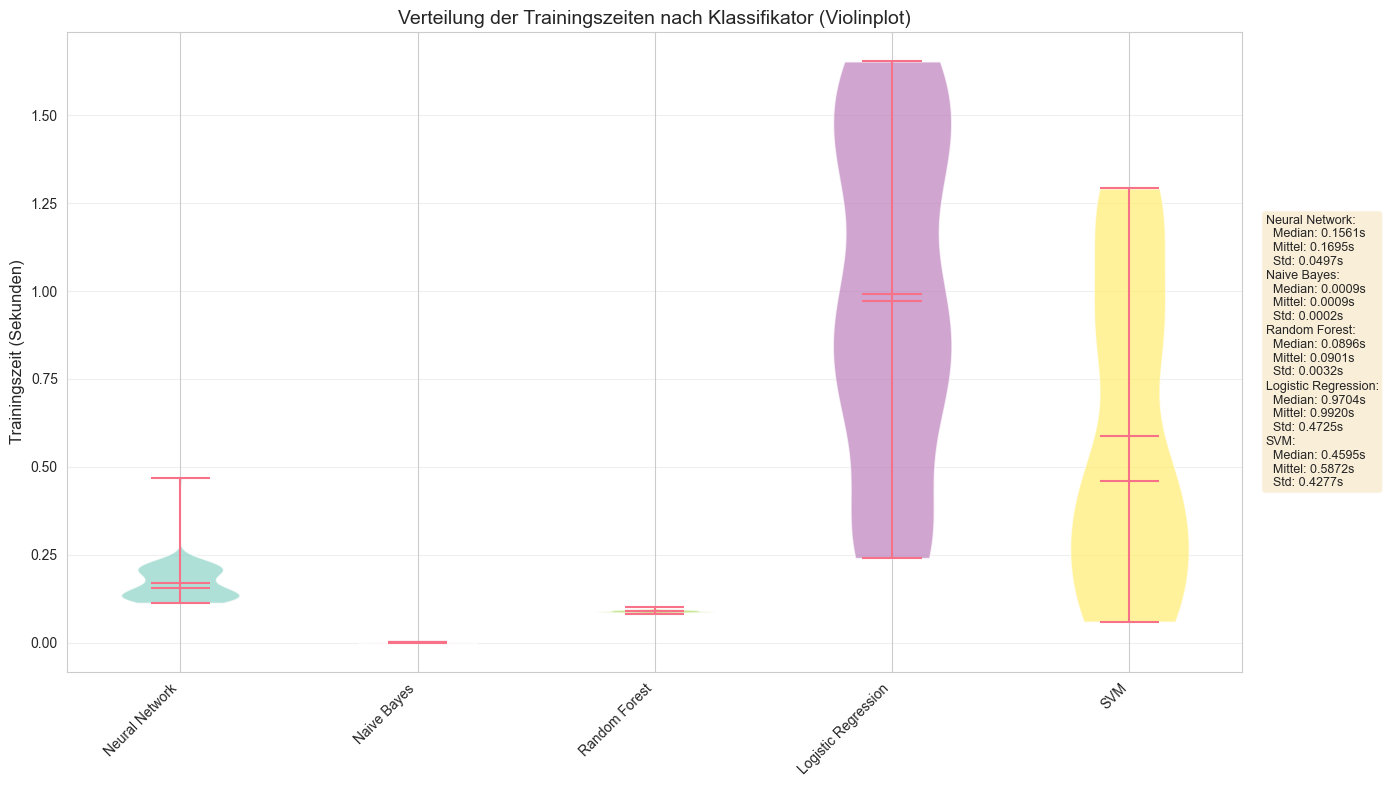

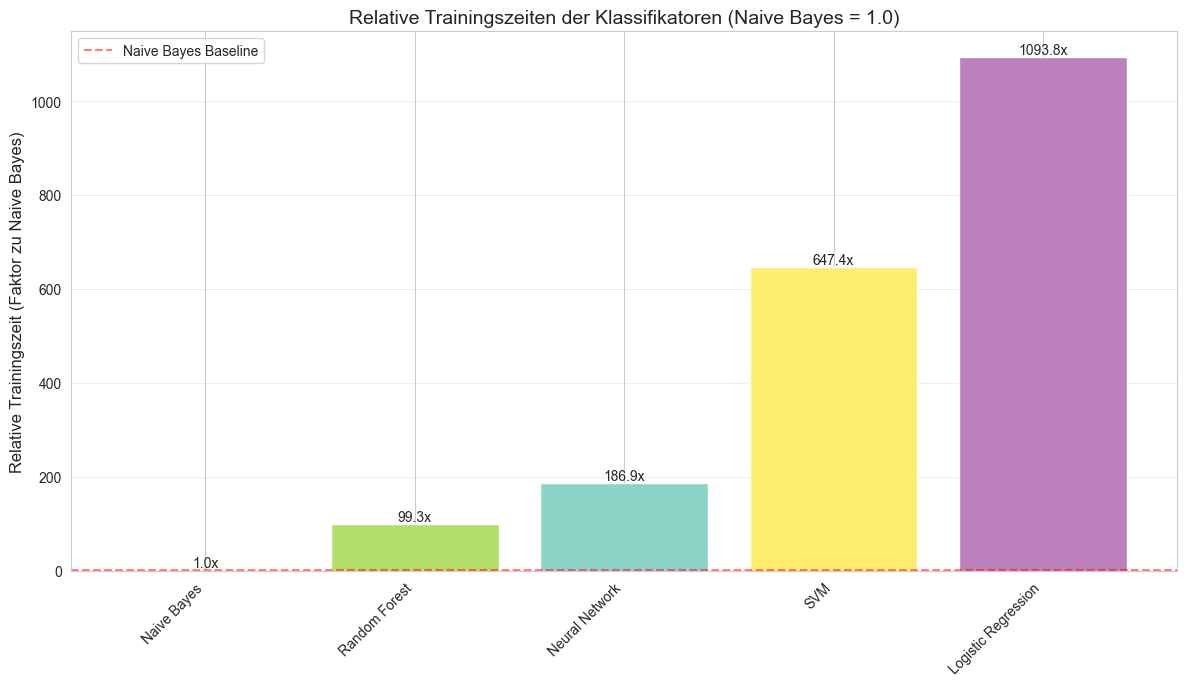

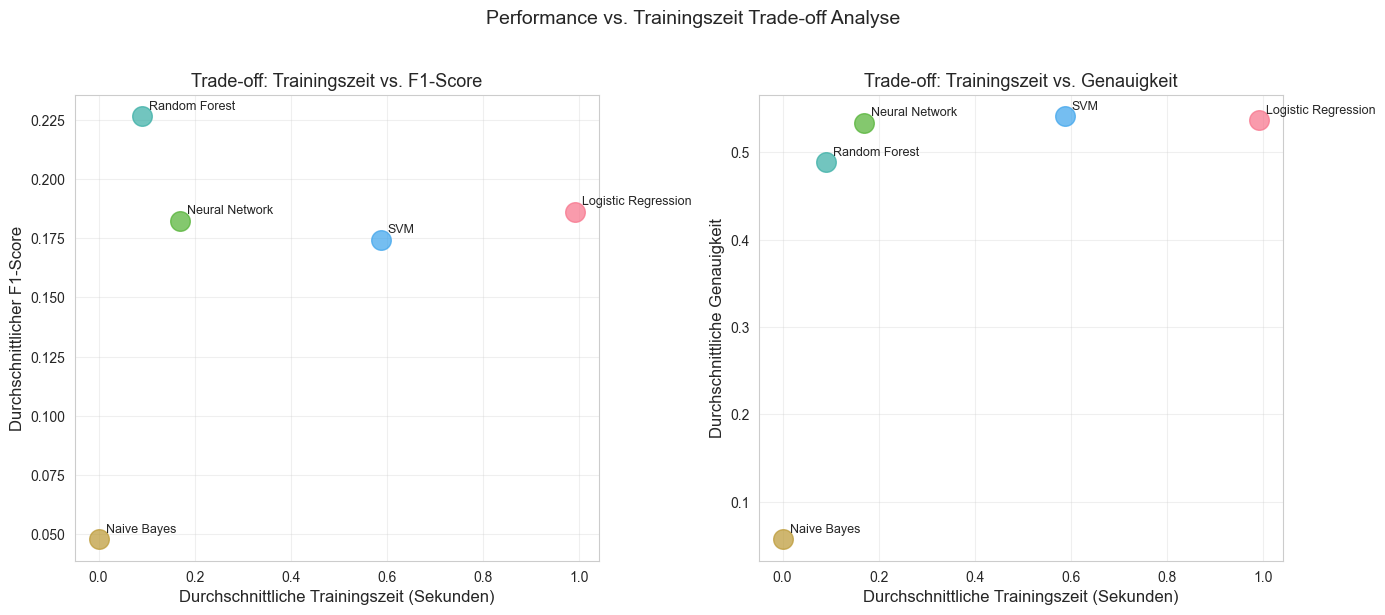

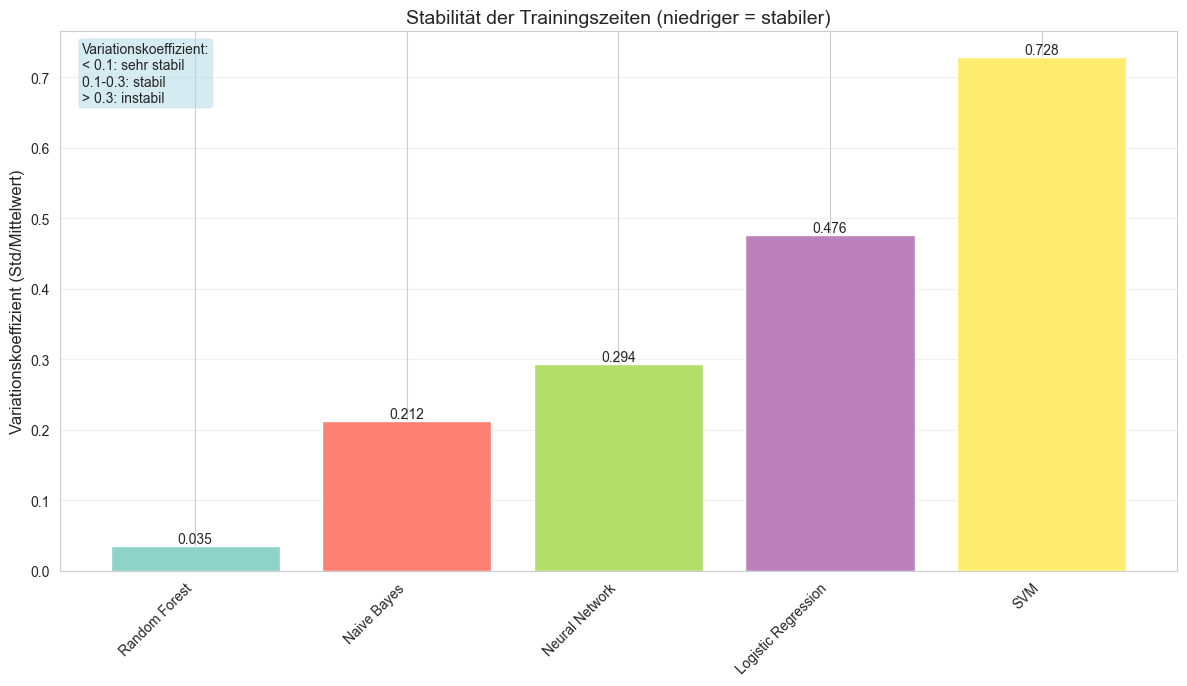


ZUSAMMENFASSUNG DER ANALYSE

1. TRAININGSZEITEN-RANKING (schnellste zu langsamste):
   1. Naive Bayes         : 0.000907 Sekunden
   2. Random Forest       : 0.090095 Sekunden
   3. Neural Network      : 0.169485 Sekunden
   4. SVM                 : 0.587174 Sekunden
   5. Logistic Regression : 0.991966 Sekunden

2. EINFLUSS DER QUERY-STRATEGIE:
   Maximale Differenz: 0.003892 Sekunden
   Relative Differenz: 1.06%

3. EINFLUSS DES BUDGETS:
   Trainingszeit bei 20% Budget: 0.116862 Sekunden
   Trainingszeit bei 100% Budget: 0.636223 Sekunden
   Steigerung: 444.42%

4. EFFIZIENTESTE KONFIGURATIONEN (F1-Score / Trainingszeit):
 classifier         strategy  budget_pct  f1_score  avg_train_time  efficiency
Naive Bayes Entropy Sampling         0.2  0.115440        0.000623  185.371969
Naive Bayes  Margin Sampling         0.2  0.103347        0.000613  168.533550
Naive Bayes Least Confidence         0.2  0.103205        0.000662  156.008316
Naive Bayes  Margin Sampling         0.2  0.084213 

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Active Learning Trainingszeiten-Analyse
Bachelorarbeit - Dachmaterial F1 Experimente
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')

# Matplotlib und Seaborn Konfiguration
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (12, 8)

# Seaborn Style
sns.set_style("whitegrid")
sns.set_palette("husl")

# Daten einlesen
df = pd.read_csv('dachmaterial_f1_active_learning_ergebnisse.csv')

print("="*80)
print("ACTIVE LEARNING TRAININGSZEITEN-ANALYSE")
print("="*80)
print(f"\nDatensatz geladen: {len(df)} Einträge")
print(f"Klassifikatoren: {df['classifier'].nunique()}")
print(f"Query-Strategien: {df['strategy'].nunique()}")
print(f"Budget-Stufen: {df['budget_pct'].nunique()}")
print(f"Wiederholungen pro Konfiguration: {df['run'].nunique()}")

# PDF für alle Plots erstellen
pdf_filename = 'trainingszeiten_analyse.pdf'
pdf = PdfPages(pdf_filename)

# =============================================================================
# PLOT 1: Übersicht - Trainingszeiten nach Klassifikator (Boxplot mit Log-Skala)
# =============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot mit linearer Skala
bp1 = ax1.boxplot([df[df['classifier'] == clf]['avg_train_time'].values 
                    for clf in df['classifier'].unique()],
                   labels=df['classifier'].unique(),
                   patch_artist=True,
                   showmeans=True,
                   meanprops=dict(marker='D', markerfacecolor='red', markersize=6))

# Farben für Boxen
colors = plt.cm.Set3(np.linspace(0, 1, len(df['classifier'].unique())))
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_xlabel('Klassifikator')
ax1.set_ylabel('Trainingszeit (Sekunden)')
ax1.set_title('Trainingszeiten nach Klassifikator (Linear)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Boxplot mit logarithmischer Skala
bp2 = ax2.boxplot([df[df['classifier'] == clf]['avg_train_time'].values 
                    for clf in df['classifier'].unique()],
                   labels=df['classifier'].unique(),
                   patch_artist=True,
                   showmeans=True,
                   meanprops=dict(marker='D', markerfacecolor='red', markersize=6))

for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_yscale('log')
ax2.set_xlabel('Klassifikator')
ax2.set_ylabel('Trainingszeit (Sekunden, log-Skala)')
ax2.set_title('Trainingszeiten nach Klassifikator (Logarithmisch)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, which='both')

plt.suptitle('Vergleich der Trainingszeiten verschiedener Klassifikatoren', fontsize=14, y=1.02)
plt.tight_layout()
pdf.savefig(fig, bbox_inches='tight')
plt.show()

# =============================================================================
# PLOT 2: Trainingszeiten über Budget-Entwicklung
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

classifiers = df['classifier'].unique()
for idx, clf in enumerate(classifiers):
    ax = axes[idx]
    clf_data = df[df['classifier'] == clf]
    
    # Gruppierung nach Budget und Strategie
    grouped = clf_data.groupby(['budget_pct', 'strategy'])['avg_train_time'].agg(['mean', 'std'])
    
    # Plot für jede Strategie
    for strategy in df['strategy'].unique():
        strategy_data = grouped.xs(strategy, level='strategy')
        ax.errorbar(strategy_data.index * 100, 
                   strategy_data['mean'],
                   yerr=strategy_data['std'],
                   marker='o', 
                   capsize=5,
                   label=strategy,
                   alpha=0.8,
                   linewidth=2)
    
    ax.set_xlabel('Budget (%)')
    ax.set_ylabel('Trainingszeit (Sekunden)')
    ax.set_title(f'{clf}')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=8)
    
    # Dynamische Y-Achsen-Skalierung
    y_range = ax.get_ylim()
    if (y_range[1] - y_range[0]) < 0.01:  # Sehr kleine Unterschiede
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Leeres Subplot entfernen falls notwendig
if len(classifiers) < 6:
    fig.delaxes(axes[-1])

plt.suptitle('Trainingszeit-Entwicklung über Budget für verschiedene Query-Strategien', 
             fontsize=14, y=1.02)
plt.tight_layout()
pdf.savefig(fig, bbox_inches='tight')
plt.show()

# =============================================================================
# PLOT 3: Heatmap - Durchschnittliche Trainingszeiten
# =============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap 1: Klassifikator vs Query-Strategie
pivot1 = df.pivot_table(values='avg_train_time', 
                        index='classifier', 
                        columns='strategy', 
                        aggfunc='mean')

sns.heatmap(pivot1, annot=True, fmt='.4f', cmap='YlOrRd', 
            cbar_kws={'label': 'Trainingszeit (Sekunden)'}, ax=ax1)
ax1.set_title('Durchschnittliche Trainingszeiten: Klassifikator vs Query-Strategie')
ax1.set_xlabel('Query-Strategie')
ax1.set_ylabel('Klassifikator')

# Heatmap 2: Klassifikator vs Budget
pivot2 = df.pivot_table(values='avg_train_time', 
                        index='classifier', 
                        columns='budget_pct', 
                        aggfunc='mean')
pivot2.columns = [f'{int(col*100)}%' for col in pivot2.columns]

sns.heatmap(pivot2, annot=True, fmt='.4f', cmap='YlOrRd',
            cbar_kws={'label': 'Trainingszeit (Sekunden)'}, ax=ax2)
ax2.set_title('Durchschnittliche Trainingszeiten: Klassifikator vs Budget')
ax2.set_xlabel('Budget')
ax2.set_ylabel('Klassifikator')

plt.tight_layout()
pdf.savefig(fig, bbox_inches='tight')
plt.show()

# =============================================================================
# PLOT 4: Violinplot - Verteilung der Trainingszeiten
# =============================================================================
fig, ax = plt.subplots(figsize=(14, 8))

# Violinplot für alle Klassifikatoren
parts = ax.violinplot([df[df['classifier'] == clf]['avg_train_time'].values 
                       for clf in df['classifier'].unique()],
                      positions=range(len(df['classifier'].unique())),
                      showmeans=True,
                      showmedians=True,
                      showextrema=True)

# Farben anpassen
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

ax.set_xticks(range(len(df['classifier'].unique())))
ax.set_xticklabels(df['classifier'].unique(), rotation=45, ha='right')
ax.set_ylabel('Trainingszeit (Sekunden)')
ax.set_title('Verteilung der Trainingszeiten nach Klassifikator (Violinplot)', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Statistiken hinzufügen
stats_text = []
for i, clf in enumerate(df['classifier'].unique()):
    clf_times = df[df['classifier'] == clf]['avg_train_time']
    stats_text.append(f"{clf}:\n"
                     f"  Median: {clf_times.median():.4f}s\n"
                     f"  Mittel: {clf_times.mean():.4f}s\n"
                     f"  Std: {clf_times.std():.4f}s")

# Textbox mit Statistiken
textstr = '\n'.join(stats_text)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(1.02, 0.5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='center', bbox=props)

plt.tight_layout()
pdf.savefig(fig, bbox_inches='tight')
plt.show()

# =============================================================================
# PLOT 5: Relative Trainingszeiten (Naive Bayes als Baseline)
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 7))

# Naive Bayes als Baseline verwenden
baseline_clf = 'Naive Bayes'
baseline_time = df[df['classifier'] == baseline_clf]['avg_train_time'].mean()

# Relative Zeiten berechnen
relative_times = []
clf_names = []
for clf in df['classifier'].unique():
    mean_time = df[df['classifier'] == clf]['avg_train_time'].mean()
    relative_times.append(mean_time / baseline_time)
    clf_names.append(clf)

# Sortieren nach relativer Zeit
sorted_indices = np.argsort(relative_times)
sorted_times = [relative_times[i] for i in sorted_indices]
sorted_names = [clf_names[i] for i in sorted_indices]

# Barplot
bars = ax.bar(range(len(sorted_names)), sorted_times, color=colors[sorted_indices])
ax.set_xticks(range(len(sorted_names)))
ax.set_xticklabels(sorted_names, rotation=45, ha='right')
ax.set_ylabel(f'Relative Trainingszeit (Faktor zu {baseline_clf})')
ax.set_title(f'Relative Trainingszeiten der Klassifikatoren ({baseline_clf} = 1.0)', fontsize=14)
ax.axhline(y=1, color='r', linestyle='--', alpha=0.5, label=f'{baseline_clf} Baseline')
ax.grid(True, alpha=0.3, axis='y')

# Werte auf den Balken anzeigen
for i, (bar, value) in enumerate(zip(bars, sorted_times)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{value:.1f}x',
           ha='center', va='bottom', fontsize=10)

ax.legend()
plt.tight_layout()
pdf.savefig(fig, bbox_inches='tight')
plt.show()

# =============================================================================
# PLOT 6: Trainingszeit vs. Performance Trade-off
# =============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Aggregierte Daten pro Klassifikator
agg_data = df.groupby('classifier').agg({
    'avg_train_time': 'mean',
    'f1_score': 'mean',
    'accuracy': 'mean'
}).reset_index()

# Plot 1: Trainingszeit vs F1-Score
for i, row in agg_data.iterrows():
    ax1.scatter(row['avg_train_time'], row['f1_score'], 
               s=200, alpha=0.7, label=row['classifier'])
    ax1.annotate(row['classifier'], 
                (row['avg_train_time'], row['f1_score']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax1.set_xlabel('Durchschnittliche Trainingszeit (Sekunden)')
ax1.set_ylabel('Durchschnittlicher F1-Score')
ax1.set_title('Trade-off: Trainingszeit vs. F1-Score')
ax1.grid(True, alpha=0.3)

# Plot 2: Trainingszeit vs Accuracy
for i, row in agg_data.iterrows():
    ax2.scatter(row['avg_train_time'], row['accuracy'], 
               s=200, alpha=0.7, label=row['classifier'])
    ax2.annotate(row['classifier'], 
                (row['avg_train_time'], row['accuracy']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax2.set_xlabel('Durchschnittliche Trainingszeit (Sekunden)')
ax2.set_ylabel('Durchschnittliche Genauigkeit')
ax2.set_title('Trade-off: Trainingszeit vs. Genauigkeit')
ax2.grid(True, alpha=0.3)

plt.suptitle('Performance vs. Trainingszeit Trade-off Analyse', fontsize=14, y=1.02)
plt.tight_layout()
pdf.savefig(fig, bbox_inches='tight')
plt.show()

# =============================================================================
# PLOT 7: Trainingszeit-Stabilität (Variationskoeffizient)
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 7))

# Variationskoeffizient berechnen (Std/Mean)
cv_data = df.groupby('classifier')['avg_train_time'].agg(['mean', 'std'])
cv_data['cv'] = cv_data['std'] / cv_data['mean']
cv_data = cv_data.sort_values('cv')

# Barplot
bars = ax.bar(range(len(cv_data)), cv_data['cv'], color=colors)
ax.set_xticks(range(len(cv_data)))
ax.set_xticklabels(cv_data.index, rotation=45, ha='right')
ax.set_ylabel('Variationskoeffizient (Std/Mittelwert)')
ax.set_title('Stabilität der Trainingszeiten (niedriger = stabiler)', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Werte auf den Balken
for i, (bar, value) in enumerate(zip(bars, cv_data['cv'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{value:.3f}',
           ha='center', va='bottom', fontsize=10)

# Zusätzliche Informationen
info_text = "Variationskoeffizient:\n< 0.1: sehr stabil\n0.1-0.3: stabil\n> 0.3: instabil"
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
pdf.savefig(fig, bbox_inches='tight')
plt.show()

# PDF schließen
pdf.close()

# =============================================================================
# Zusammenfassung und Statistiken
# =============================================================================
print("\n" + "="*80)
print("ZUSAMMENFASSUNG DER ANALYSE")
print("="*80)

print("\n1. TRAININGSZEITEN-RANKING (schnellste zu langsamste):")
ranking = df.groupby('classifier')['avg_train_time'].mean().sort_values()
for i, (clf, time) in enumerate(ranking.items(), 1):
    print(f"   {i}. {clf:20s}: {time:.6f} Sekunden")

print("\n2. EINFLUSS DER QUERY-STRATEGIE:")
strategy_impact = df.groupby('strategy')['avg_train_time'].mean()
print(f"   Maximale Differenz: {strategy_impact.max() - strategy_impact.min():.6f} Sekunden")
print(f"   Relative Differenz: {((strategy_impact.max() / strategy_impact.min()) - 1) * 100:.2f}%")

print("\n3. EINFLUSS DES BUDGETS:")
budget_impact = df.groupby('budget_pct')['avg_train_time'].mean()
print(f"   Trainingszeit bei 20% Budget: {budget_impact[0.2]:.6f} Sekunden")
print(f"   Trainingszeit bei 100% Budget: {budget_impact[1.0]:.6f} Sekunden")
print(f"   Steigerung: {((budget_impact[1.0] / budget_impact[0.2]) - 1) * 100:.2f}%")

print("\n4. EFFIZIENTESTE KONFIGURATIONEN (F1-Score / Trainingszeit):")
df['efficiency'] = df['f1_score'] / df['avg_train_time']
best_configs = df.nlargest(5, 'efficiency')[['classifier', 'strategy', 'budget_pct', 'f1_score', 'avg_train_time', 'efficiency']]
print(best_configs.to_string(index=False))

print(f"\n✓ Alle Plots wurden erfolgreich in '{pdf_filename}' gespeichert!")
print("="*80)